In [1]:
# taking advantage of all features: codes by GenAI, based on my implementation using only voltage data
from utils import *

def load_day_data(pkl):
    with open(pkl, 'rb') as f:
        data = pickle.load(f)

    # state variables
    v_sch, t_sch = data['sch_v'], data['sch_θ']
    v_att, t_att = data['attack_v'], data['attack_θ']

    # power flow (active/reactive on branches)
    fp_sch, fq_sch = data['sch_fp'], data['sch_fq']
    fp_att, fq_att = data['attack_fp'], data['attack_fq']

    # generation dispatch
    pg_sch, qg_sch = data['sch_pg'], data['sch_qg']
    pg_att, qg_att = data['attack_pg'], data['attack_qg']

    # load curtailment (storage control signals)
    dcurt_up_sch, dcurt_dn_sch = data['sch_dcurt_up'], data['sch_dcurt_dn']
    dcurt_up_att, dcurt_dn_att = data['attack_dcurt_up'], data['attack_dcurt_dn']

    steps = [f"x{i}" for i in range(ATTACK_WINDOW[0], ATTACK_WINDOW[1] + 1) if f"x{i}" in v_sch]

    V_sch = np.array([v_sch[s] for s in steps]).T
    T_sch = np.array([t_sch[s] for s in steps]).T
    V_att = np.array([v_att.get(s, v_sch[s]) for s in steps]).T
    T_att = np.array([t_att.get(s, t_sch[s]) for s in steps]).T

    # helper: safely load arrays with dimension handling
    def safe_load(d, s, n):
        if s not in d:
            return np.zeros(n)
        arr = np.asarray(d[s])
        return arr[:n] if len(arr) >= n else np.pad(arr, (0, n - len(arr)))

    # load all power system features
    Fp_sch = np.array([safe_load(fp_sch, s, N_NODES) for s in steps]).T
    Fq_sch = np.array([safe_load(fq_sch, s, N_NODES) for s in steps]).T
    Fp_att = np.array([safe_load(fp_att, s, N_NODES) for s in steps]).T
    Fq_att = np.array([safe_load(fq_att, s, N_NODES) for s in steps]).T
    Pg_sch = np.array([safe_load(pg_sch, s, N_NODES) for s in steps]).T
    Qg_sch = np.array([safe_load(qg_sch, s, N_NODES) for s in steps]).T
    Pg_att = np.array([safe_load(pg_att, s, N_NODES) for s in steps]).T
    Qg_att = np.array([safe_load(qg_att, s, N_NODES) for s in steps]).T
    Dcurt_up_sch = np.array([safe_load(dcurt_up_sch, s, N_NODES) for s in steps]).T
    Dcurt_dn_sch = np.array([safe_load(dcurt_dn_sch, s, N_NODES) for s in steps]).T
    Dcurt_up_att = np.array([safe_load(dcurt_up_att, s, N_NODES) for s in steps]).T
    Dcurt_dn_att = np.array([safe_load(dcurt_dn_att, s, N_NODES) for s in steps]).T

    # compute deviations (attack - scheduled)
    dV, dT = V_att - V_sch, T_att - T_sch
    dFp, dFq = Fp_att - Fp_sch, Fq_att - Fq_sch
    dPg, dQg = Pg_att - Pg_sch, Qg_att - Qg_sch
    dDcurt_up, dDcurt_dn = Dcurt_up_att - Dcurt_up_sch, Dcurt_dn_att - Dcurt_dn_sch

    # feature engineering: temporal patterns + statistics
    X = np.concatenate([
        # temporal deviation patterns (46 timesteps each)
        dV, dT, dFp, dFq, dPg, dQg, dDcurt_up, dDcurt_dn,
        # baseline operational statistics
        V_sch.mean(axis=1, keepdims=True), V_sch.std(axis=1, keepdims=True),
        T_sch.mean(axis=1, keepdims=True), T_sch.std(axis=1, keepdims=True),
        Fp_sch.mean(axis=1, keepdims=True), Fp_sch.std(axis=1, keepdims=True),
        # peak deviation indicators
        np.abs(dV).max(axis=1, keepdims=True), np.abs(dT).max(axis=1, keepdims=True),
        np.abs(dFp).max(axis=1, keepdims=True), np.abs(dDcurt_up).max(axis=1, keepdims=True)
    ], axis=1)

    # labels: 1 for attacked nodes, 0 for normal (0-indexed)
    y = np.zeros(N_NODES, dtype=np.float32)
    for node in ATTACKED_NODES:
        if node < N_NODES:
            y[node] = 1.0

    return X, y

print(f"FDIA detection | full features\n")
adj = load_adj_matrix('topology.csv')
print(f"Grid topology: {N_NODES}-bus, {int(np.sum(adj)) // 2}-edge\n")
X, y, d = load_all_days(DATA, load_day_data)
print(f"Data: {X.shape}, attack ratio={y.mean():.3f}")

FDIA detection | full features

Grid topology: 187-bus, 188-edge



Loading v3: 100%|██████████| 200/200 [00:02<00:00, 93.77it/s]


Data: (809, 187, 378), attack ratio=0.016


In [11]:
X = (X - X.mean((0, 1), keepdims=True)) / (X.std((0, 1), keepdims=True) + 1e-8)
split = int(len(X) * 0.75)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

weight = (y_train.size - y_train.sum()) / (y_train.sum() + 1e-8) * 0.5
print(f"{X_train.shape[0]} training + {X_test.shape[0]} test days | positive class weight={weight:.1f}\n")

model = gcn(N_NODES, X.shape[2], adj)
model.compile(
    optimizer=keras.optimizers.Adam(3e-3), loss=WeightedBCE(pos_weight=weight),
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc', threshold=0.5),
        keras.metrics.Precision(name='prec', thresholds=0.5),
        keras.metrics.Recall(name='rec', thresholds=0.5),
        keras.metrics.AUC(name='auc')
    ]
)

hist = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=400, batch_size=32, verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, mode='max'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-6, mode='max')
    ]
)

y_pred = model.predict(X_test, verbose=0)[:, :, 0]

Split: train=606, test=203, pos_weight=30.7

Epoch 1/400
19/19 [==============================] - 1s 23ms/step - loss: 0.9434 - acc: 0.6919 - prec: 0.0340 - rec: 0.6634 - auc: 0.7221 - val_loss: 0.9987 - val_acc: 0.9783 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.4037 - lr: 3.0000e-04
Epoch 2/400
19/19 [==============================] - 0s 11ms/step - loss: 0.6219 - acc: 0.8047 - prec: 0.0751 - rec: 0.9879 - auc: 0.9451 - val_loss: 0.9843 - val_acc: 0.9813 - val_prec: 0.3891 - val_rec: 0.2939 - val_auc: 0.6046 - lr: 3.0000e-04
Epoch 3/400
19/19 [==============================] - 0s 10ms/step - loss: 0.5308 - acc: 0.8625 - prec: 0.1017 - rec: 0.9664 - auc: 0.9526 - val_loss: 0.9767 - val_acc: 0.9806 - val_prec: 0.3798 - val_rec: 0.3268 - val_auc: 0.6158 - lr: 3.0000e-04
Epoch 4/400
19/19 [==============================] - 0s 10ms/step - loss: 0.4689 - acc: 0.8832 - prec: 0.1185 - rec: 0.9763 - auc: 0.9604 - val_loss: 0.9667 - val_acc: 0.9806 - val_prec: 0.3794 - val_rec: 0


Top 10 suspicious nodes (avg prob, 1-indexed):
  163: 0.992 [ATTACK]
  33: 0.986 [ATTACK]
  34: 0.981 [ATTACK]
  112: 0.603 
  31: 0.425 
  29: 0.403 
  1: 0.179 
  30: 0.102 
  32: 0.030 
  185: 0.023 

Classification report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     37352
    attacked       0.98      0.99      0.98       609

    accuracy                           1.00     37961
   macro avg       0.99      0.99      0.99     37961
weighted avg       1.00      1.00      1.00     37961



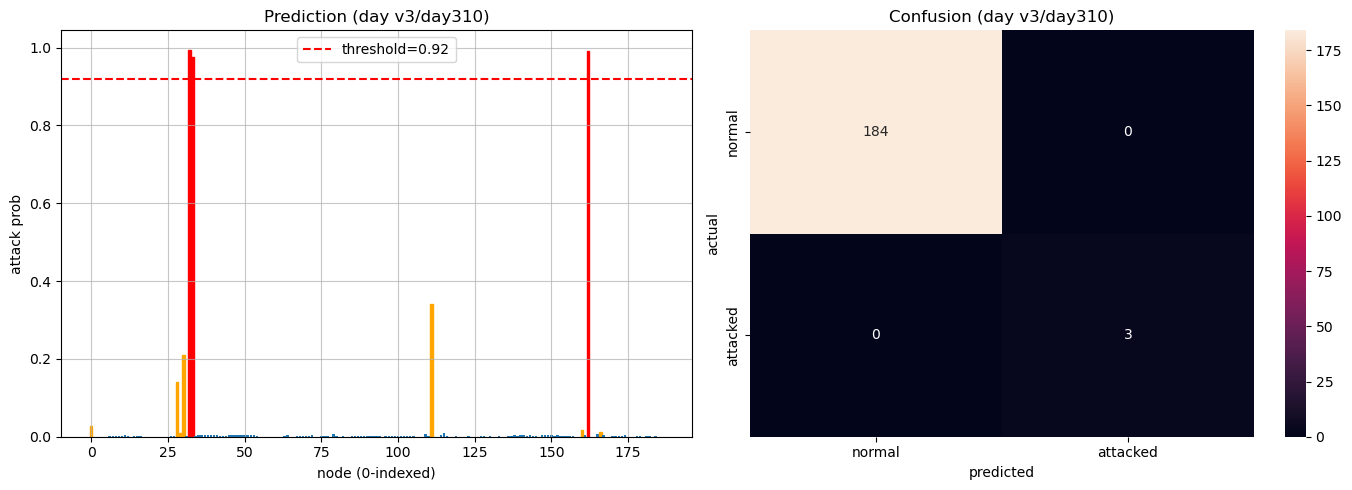

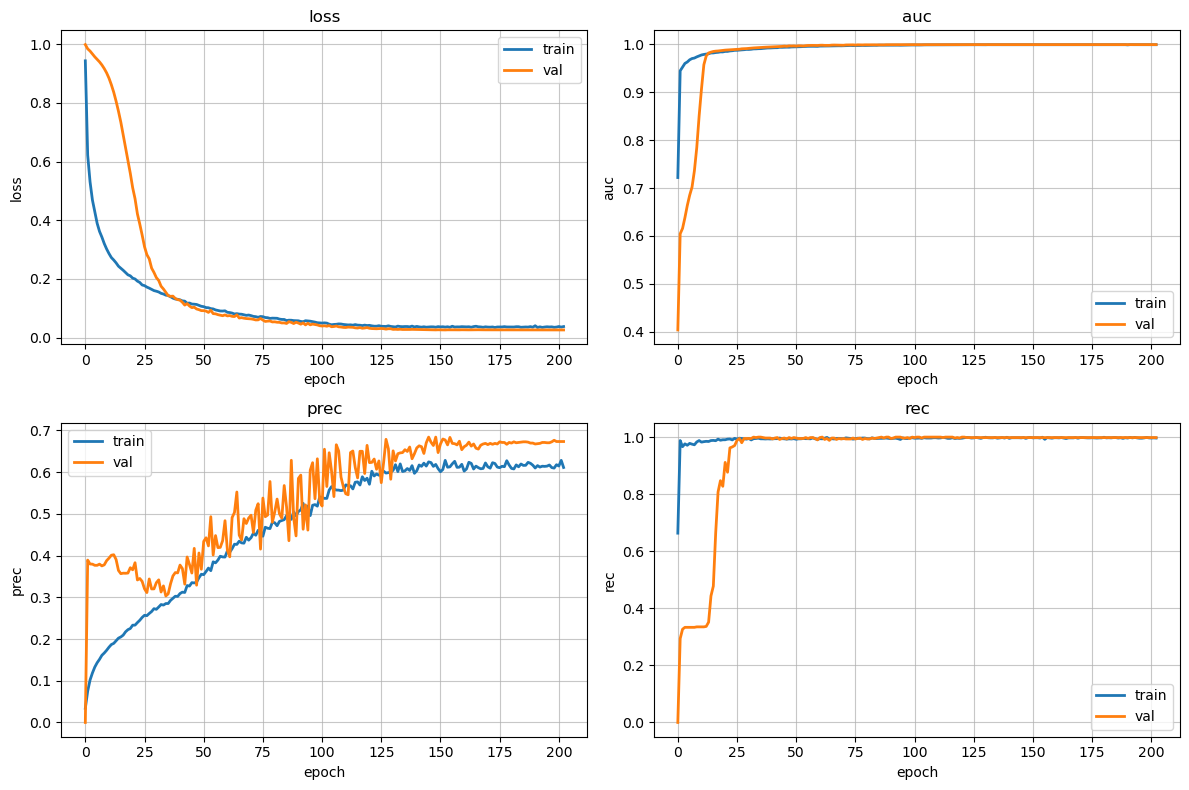

In [12]:
thresh = np.linspace(0.5, 1.0, 100)
f1 = []
for t in thresh:
    y_bin = (y_pred > t).astype(int)
    tp = ((y_bin == 1) & (y_test == 1)).sum()
    fp = ((y_bin == 1) & (y_test == 0)).sum()
    fn = ((y_bin == 0) & (y_test == 1)).sum()
    p = tp / (tp + fp + 1e-8)
    r = tp / (tp + fn + 1e-8)
    f1.append(2 * p * r / (p + r + 1e-8))

thresh_opt = thresh[np.argmax(f1)]
y_pred_bin = (y_pred > thresh_opt).astype(int)

print(f"\nTop 10 suspicious nodes (avg score across {X_test.shape[0]} test days):")
node_scores = y_pred.mean(axis=0)
for n in np.argsort(node_scores)[-10:][::-1]:
    print(f" {n + 1}: {node_scores[n]:.3f} {'[ATTACK]' if n in ATTACKED_NODES else ''}")
print("\nClassification Report")
print(classification_report(y_test.flatten(), y_pred_bin.flatten(), target_names=['normal', 'attack']))

# visualization
idx = 101
day = d[split:][idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bars = axes[0].bar(range(N_NODES), y_pred[idx])
axes[0].axhline(thresh_opt, c='r', ls='--', label=f'threshold={thresh_opt:.2f}')
for i in np.argsort(y_pred[idx])[-10:]:
    bars[i].set_color('red' if i in ATTACKED_NODES else 'orange')
axes[0].set(xlabel='node', ylabel='attack prob', title=f'PREDICTION ({day})')
axes[0].legend()
axes[0].grid(alpha=0.7)

sns.heatmap(confusion_matrix(y_test[idx], y_pred_bin[idx]), fmt='d', annot=True, ax=axes[1])
axes[1].set(xlabel='predicted', ylabel='actual', title=f'CONFUSION ({day})')
axes[1].set_xticklabels(['normal', 'attacked'])
axes[1].set_yticklabels(['normal', 'attacked'])

plt.tight_layout()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, k in enumerate(['loss', 'auc', 'prec', 'rec']):
    ax = axes[i // 2, i % 2]
    ax.plot(hist.history[k], label='train')
    ax.plot(hist.history[f'val_{k}'], label='val')
    ax.set(xlabel='ep', ylabel=k, title=k)
    ax.legend()
    ax.grid(alpha=0.7)

plt.tight_layout()